## Looking at the DSL by Michael Hodel 

* https://github.com/michaelhodel/arc-dsl

Now significantly re-engineered at :

* https://github.com/mdda/arc-dsl-llm


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
DSL_BASE='./External/arc-dsl-llm'

path = list(sys.path)
sys.path.insert(0, DSL_BASE)
try:
  import arc_dsl
finally:
  sys.path[:] = path # restore
print(arc_dsl.__file__)

/mnt/rdai/reddragon/research/ARC-diffusion/External/arc-dsl-llm/arc_dsl/__init__.py


In [3]:
import arc_dsl.main
#dir(arc_dsl.main)
dsl_functions, dsl_functionals = arc_dsl.main.get_functions(f"{DSL_BASE}/dsl.py")
len(dsl_functions), len(dsl_functionals)

(162, 7)

In [4]:
constants = arc_dsl.main.get_constants(f"{DSL_BASE}/constants.py")
len(constants)

30

In [5]:
import arc_dsl.solvers
definitions = arc_dsl.main.get_definitions(arc_dsl.solvers)
len(definitions)

400

In [6]:
task_hash = '00d62c1b'  # inside->yellow
#task_hash = 'ff28f65a'
#task_hash = '0a938d79'
#task_hash = '6855a6e4' # Long one
#task_hash = '0a938d79' # Parsing problem...
#task_hash = '3345333e' # Possible one-shot example
#task_hash = 'caa06a1f'  # test case not same as training... (TOO LARGE FOR COMBINATORIAL THING BELOW without length limit)

key = [k for k in definitions.keys() if task_hash in k ][0]
definition = definitions[key]

In [7]:
import arc_mdda.dsl_manipulation

def_lines = arc_mdda.dsl_manipulation.analyse_definition(definition, dsl_functions, constants, dsl_functionals)
for def_line in def_lines:
  print(def_line)

 0[0]: I = input_value()                           : used_by:{1, 3, 6} .. uses:set()
 1[5]: x1 = as_objects(I, True, False, False)      : used_by:{2} .. uses:{0}
 2[3]: x2 = color_filter(x1, COLOR_ZERO)           : used_by:{5} .. uses:{1}
 3[3]: x3 = fix_last_argument(bordering, I)        : used_by:{4} .. uses:{0}
 4[3]: x4 = compose(logical_not, x3)               : used_by:{5} .. uses:{3}
 5[3]: x5 = keep_if_condition_and_flatten(x2, x4)  : used_by:{6} .. uses:{2, 4}
 6[4]: O = fill(I, COLOR_FOUR, x5)                 : used_by:{7} .. uses:{0, 5}
 7[0]:  = return(O)                                : used_by:set() .. uses:{6}


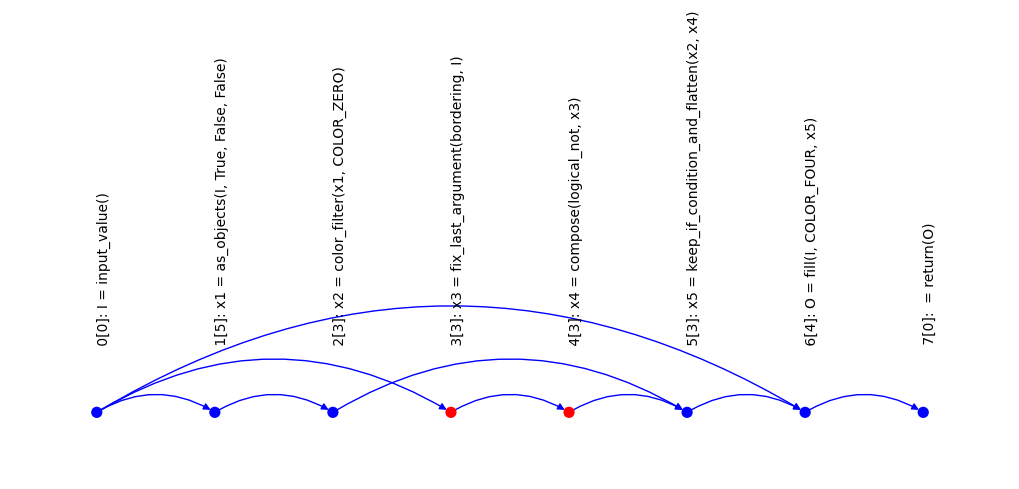

In [8]:
# Original example from : https://stackoverflow.com/questions/73895995/how-to-create-scatter-plot-with-multiple-connecting-lines-in-python
#   https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx_edges.html
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()
#N_nodes = len(def_lines)

pos, node_color = dict(), []
for idx, def_line in enumerate(def_lines):
  G.add_node(idx)
  node_color.append('red' if def_line.is_function_type else 'blue')
  for uses_idx in def_line.uses:
    G.add_edge(uses_idx, idx)
  pos[idx] = [idx, 0]

plt.figure(figsize=(10,2))
nx.draw(G, pos=pos, connectionstyle="arc3,rad=-0.3", edge_color='blue', node_color=node_color, node_size=50)
for idx, def_line in enumerate(def_lines):
  plt.text(idx,0.5, def_line.repr_base(), rotation=90.)
plt.ylim([-0.5, 1.0])
plt.show()

### Evaluate solutions, capturing steps

In [9]:
fundef="""
def myfun(a):
  return a*2
def myfun(a):
  return a*4
"""

exec(fundef)
myfun(23)

92

In [10]:
solver_new = arc_mdda.dsl_manipulation.create_virtual_solver(def_lines) # , dsl_functions=dsl_functions
print( solver_new )

def solver_virtual(I):
  x1 = as_objects(I, True, False, False)
  x2 = color_filter(x1, COLOR_ZERO)
  x3 = fix_last_argument(bordering, I)
  x4 = compose(logical_not, x3)
  x5 = keep_if_condition_and_flatten(x2, x4)
  O = fill(I, COLOR_FOUR, x5)
  return dict(I=I,x1=x1,x2=x2,x5=x5,O=O)


In [11]:
color_constants_remap_indices=[ i for i in [5,6,7,8,9,0,1,2,3,4, 10, -1] ]
color_constants_remap = [ arc_mdda.dsl_manipulation.color_constants_base[i] for i in color_constants_remap_indices ]
grid_to_tuples_remapped = lambda g: tuple(tuple(color_constants_remap_indices[c]+arc_mdda.dsl_manipulation.color_constants_zero for c in r) for r in g)
#color_constants_remap
#print( arc_mdda.dsl_manipulation.create_virtual_solver(def_lines, dsl_functions=dsl_functions) )
print( arc_mdda.dsl_manipulation.create_virtual_solver(def_lines, 
                    color_constants=color_constants_remap, dsl_functions=dsl_functions) )

def solver_virtual(I):
  x1 = as_objects(grid=I, discard_background=False)
  x2 = color_filter(objs=x1, color=COLOR_FIVE)
  x3 = fix_last_argument(function=bordering, fixed_arg=I)
  x4 = compose(outer=logical_not, inner=x3)
  x5 = keep_if_condition_and_flatten(container=x2, condition=x4)
  O = fill(grid=I, color=COLOR_NINE, patch=x5)
  return dict(I=I,x1=x1,x2=x2,x5=x5,O=O)


### Run exec() on actual training example (need the examples)

In [12]:
import arc_mdda
data_train = arc_mdda.load_json_data('./External/ARC-AGI/data/training/')
len(data_train), list(data_train.keys())[0:4]

(400, ['4be741c5', '3aa6fb7a', 'ce4f8723', 'ff28f65a'])

In [13]:
# https://stackoverflow.com/questions/24733831/using-a-function-defined-in-an-execed-string-in-python-3

## Commented out to avoid polluting our namespace (and security, maybe...)
##   https://blog.finxter.com/how-to-import-libraries-in-pythons-exec-function/
#from arc_dsl.dsl import *
#from arc_dsl.constants import *
#from arc_dsl.main import grid_to_tuples

#grid_to_tuples = lambda g: tuple(tuple(c+arc_mdda.dsl_manipulation.color_constants_zero for c in r) for r in g)
grid_to_tuples = arc_mdda.dsl_manipulation.grid_to_tuples

import_preamble="""
from arc_dsl.dsl import *
from arc_dsl.constants import *
"""

color_map_preamble=(
  ",".join(['COLOR_BELOW'] + arc_mdda.dsl_manipulation.color_constants_base[:-1])
  + " = "
  + ",".join([f"{i+arc_mdda.dsl_manipulation.color_constants_zero}" for i in range(-1,10+1)])
  + "\n"
)

solver_globals = dict( arc_dsl=arc_dsl )
#exec_solver_globals = { 'arc_dsl':arc_dsl, '__builtins__':None }  # Clearly we need some built-in functions

# Let's see whether we can evaluate the test case through our virtual solver
exec(import_preamble + color_map_preamble + solver_new, solver_globals) # Defines solver_virtual(I)

task_test_data = data_train[task_hash]['test']
I = grid_to_tuples( task_test_data[0]['input'] )
O = grid_to_tuples( task_test_data[0]['output'] )

#O_dict = solver_virtual(I)
O_dict = solver_globals['solver_virtual'](I)

len(O_dict), O_dict['O'] == O   # YAY - after converting original JSON [[]] data to tuples

(5, True)

In [14]:
color_map_preamble

'COLOR_BELOW,COLOR_ZERO,COLOR_ONE,COLOR_TWO,COLOR_THREE,COLOR_FOUR,COLOR_FIVE,COLOR_SIX,COLOR_SEVEN,COLOR_EIGHT,COLOR_NINE,COLOR_ABOVE = 1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020\n'

In [15]:
#solver_globals['as_objects'], #as_objects
#O_dict['O']

### Run exec() over all training examples - check on COLOR_ permutation

In [16]:
# Let's test all the solvers now...
if False: 
  for k, definition in sorted(definitions.items()):
    task_hash = k.replace('solve_', '')
    
    def_lines = arc_mdda.dsl_manipulation.analyse_definition(definition, dsl_functions, constants, dsl_functionals)
  
    if True:
      grid_to_tuples_fn = grid_to_tuples
      color_constants = arc_mdda.dsl_manipulation.color_constants_base
    else:  # REMAP THE COLORS!
      grid_to_tuples_fn = grid_to_tuples_remapped
      color_constants=color_constants_remap
    solver_py = arc_mdda.dsl_manipulation.create_virtual_solver(def_lines, color_constants=color_constants)
    
    task_test_data = data_train[task_hash]['test']
    I = grid_to_tuples_fn( task_test_data[0]['input'] )
    O = grid_to_tuples_fn( task_test_data[0]['output'] )

    #exec(import_preamble + color_map_preamble + solver_new, solver_globals) # Defines solver_virtual(I)
    #O_dict = solver_globals['solver_virtual'](I)
    solver_function = arc_mdda.dsl_manipulation.get_solver_function(solver_py, arc_dsl)
    O_dict = solver_function(I)
    
    #if task_hash=='995c5fa3':
    #  break
    success = (O_dict['O'] == O)
    if not success:
      print(task_hash, O_dict['O'] == O, len(solver_new))
      
    for k,v in O_dict.items():
      t=arc_mdda.dsl_manipulation.detect_type(v)
      if t is None:
        print(task_hash, k, type(v))
        #print(v)
        #success=False
    if not success: break
  print("FINISHED!")

### Examine the I/O and intermediate variables

In [17]:
task_hash

'00d62c1b'

In [18]:
O_dict.keys()

dict_keys(['I', 'x1', 'x2', 'x5', 'O'])

In [19]:
#from arc_dsl.arc_types import *
# NB: Now the COLOR values are all >1000, so can detect the type based on that...

color_tokens='x r b y e q c z p u w q'.split(' ')

#detect_type(O_dict['x1'], )
for k,v in O_dict.items():
  t=arc_mdda.dsl_manipulation.detect_type(v)
  print(f" {k} is {t}")
  print(f"    = {arc_mdda.dsl_manipulation.render_variable(v,t,color_tokens)}") 

 I is Grid
    = Grid(
 x x x x x x x x x x x x x x x x x x x x
 x x y x x x x x x x x x x x x x x x x x
 x y x y y x x x x x x x x x x x x x x x
 x x y x y y y y y x y y x x x x x x x x
 x x x x y x x x x y x x y x x x x x x x
 x x x x y y y y y x y y y x x x x x x x
 x x x x x x x x x x x x x y y y y y x x
 x x x x x x x x x x x x x y x x x y x x
 x x x x x x x x x x x x x y x x x y x x
 x x x x x x x x x y y y y y x x x y x x
 x x x x x x x x x y x x x y x x x y x x
 x x x x x x x x y y y y y y x x x y x x
 x x x x x x y y x y x x x y y y y y x x
 x x y x x x x x y y x x x x x x x x x x
 x y x y x x x x x x x x x x x x x x x x
 x x y x y x y y y y y y x x x x x x x x
 x x x x x x x y x x x y x x x x x x x x
 x x x x x x x y x x x y x x x x x x x x
 x x x x x x x y y y y y x x x x x x x x
 x x x x x x x x x x x x x x x x x x x x
)
 x1 is Objects
    = Objects(
 Object(( x,(9,15)),( x,(11,14)),( x,(10,15)),( x,(11,16)),( x,(8,14)),( x,(7,14)),( x,(8,16)),( x,(9,14)),( x,(7,16)),( x,(8

In [20]:
#O_dict['O'], O

In [21]:
#print(definition)
#O_dict['x7']

### Output DSL functionality as LLM-readable text

In [22]:
arr = arc_mdda.dsl_manipulation.get_dsl_documentation(DSL_BASE)
#print('\n'.join(arr))
print(f"{len(arr)} lines in the 'DSL manual'")

327 lines in the 'DSL manual'


In [23]:
if False:  # Show analysis of usage frequency of the DSL functions
  function_usage_count={ k:0 for k in dsl_functions.keys() }
  for k, definition in sorted(definitions.items()):
    def_lines = arc_mdda.dsl_manipulation.analyse_definition(definition, dsl_functions, constants, dsl_functionals)
    for def_line in def_lines:
      for function in ([def_line.function] + def_line.args):
        if not function in dsl_functions: continue
        function_usage_count[function]+=1
        
  print("functions with small numbers of demonstration examples")
  for k in sorted(function_usage_count.keys(), key=lambda k:-function_usage_count[k]):
    cnt = function_usage_count[k]
    if cnt>5: continue   # Long tail ...
    print(f"  demos = {cnt:<4d} : {k}")

## Now try and enumerate all possible 'function chunks' within a solution

In [24]:
def_lines

[ 0[0]: I = input_value()                           : used_by:{1, 3, 6} .. uses:set(),
  1[5]: x1 = as_objects(I, True, False, False)      : used_by:{2} .. uses:{0},
  2[3]: x2 = color_filter(x1, COLOR_ZERO)           : used_by:{5} .. uses:{1},
  3[3]: x3 = fix_last_argument(bordering, I)        : used_by:{4} .. uses:{0},
  4[3]: x4 = compose(logical_not, x3)               : used_by:{5} .. uses:{3},
  5[3]: x5 = keep_if_condition_and_flatten(x2, x4)  : used_by:{6} .. uses:{2, 4},
  6[4]: O = fill(I, COLOR_FOUR, x5)                 : used_by:{7} .. uses:{0, 5},
  7[0]:  = return(O)                                : used_by:set() .. uses:{6}]

In [25]:
def combinations(arr):   # This returns all combinations of [a,b,c] = [], [a], [b], [c], [a,b], [b,c], [a,c], [a,b,c]
  if len(arr) == 0: return [[]]
  cs = []
  for c in combinations(arr[1:]):
    cs += [c, [arr[0],]+c]
  return cs
#print( combinations([(1,),(2,3),(4,23,2324)]) )
#print( combinations(['a', 'b', 'c']) )

cross_list_empty=tuple()
def all_possible_cross_lists(arr): # [abc, AB] = "", "A", "B", "a", "aA", "aB", "b", "bA", "bB", "c", "cA", "cB"
  # Actually arr is a list of sets of tuples.  Returns a list tuples (each combo element gets combined)
  #print(arr)
  cl = []
  first_element_with_empty = [cross_list_empty,] + list( arr[0] )
  for first in first_element_with_empty:
    #print(first_element_with_empty, first)
    if len(arr)==1:
      cl.append(first)
    else:
      for e in all_possible_cross_lists(arr[1:]):
        cl.append(first+e)
        #print(f"{arr=} {first=} {e=} {first+e=} {cl=}")
  return cl
if False:
  cross_list_empty=''
  print( all_possible_cross_lists([list("abc"), list("AB")]) )
  cross_list_empty=tuple(); 
print( all_possible_cross_lists([set([(1,),(2,)]), set([(5,6,),(15,16,17),(22,)])]) )

[(), (15, 16, 17), (5, 6), (22,), (1,), (1, 15, 16, 17), (1, 5, 6), (1, 22), (2,), (2, 15, 16, 17), (2, 5, 6), (2, 22)]


In [26]:
#PAUSE : if the number of lines > 22 then we're going to try to look at 2**22 combinations (potentially)

In [27]:
def get_all_chunks_starting(idx, def_lines=def_lines, max_depth=8):
  maybethis_plus_ancestors = (
    [set([(idx,),]), ] 
    + [ get_all_chunks_starting(i, def_lines, max_depth=max_depth-1) 
       for i in def_lines[idx].uses if i!=0 ]
  )
  #print(f"{ancestors=}")
  # Simplify list, since 'sorted uniquified tuples' should be unique
  combinations_of_ancestors = set( 
    [ tuple(sorted(set(t))) for t in all_possible_cross_lists(maybethis_plus_ancestors) 
                            if len(set(t))<=max_depth ]  
  )
  #print(f"{combinations_of_ancestors=}")
  return combinations_of_ancestors

all_chunks=set()
for i in range(1, len(def_lines)-1):
  all_chunks.update( get_all_chunks_starting( i, max_depth=5 ) )
  print(i, len(all_chunks))
  #if i>16: break
print(len(def_lines)-2, len(all_chunks))
#for c in all_chunks:
#  print(c)

1 2
2 4
3 5
4 7
5 32
6 63
6 63


In [28]:
def get_possible_functions(all_chunks, max_inputs=1, image_is_free=True, def_lines=def_lines):
  valid_functions=[]
  for possible_fn in all_chunks:
    inside = set(possible_fn)  # These are inside the function
    if len(inside)<=1:  # Single line (or zero-line) functions are useless
      continue  
    used_inputs, used_outside=set(), False
    for i in possible_fn:
      for possible_input in def_lines[i].uses:
        if possible_input in inside: 
          continue  # This is inside the function already - no need to worry
        used_inputs.add(possible_input)
    if len(possible_fn)>0:
      for i in possible_fn[:-1]:  # Only last element should be used outside this function
        for j in def_lines[i].used_by:
          if j not in inside: 
            used_outside=True
    if image_is_free:
       used_inputs.discard(0)  # 0 is the index where the input variable 'I' is given
    functional_input=False
    for i in used_inputs:
      if def_lines[i].is_function_type: 
        functional_input=True # Don't allow this kind of input
    functional_output = def_lines[ possible_fn[-1] ].is_function_type  # Don't allow this kind of output
    if len(used_inputs)<=max_inputs and (not used_outside) and (not functional_input) and (not functional_output):  # This is valid
      valid_functions.append(possible_fn)
  return valid_functions
#possible_functions = get_possible_functions(all_chunks, max_inputs=2, image_is_free=False)
possible_functions = get_possible_functions(all_chunks, max_inputs=1, image_is_free=True)
print(len(possible_functions))
sorted(possible_functions)

6


[(1, 2),
 (1, 2, 3, 4, 5),
 (2, 3, 4, 5),
 (2, 3, 4, 5, 6),
 (3, 4, 5),
 (3, 4, 5, 6)]

In [29]:
def_lines

[ 0[0]: I = input_value()                           : used_by:{1, 3, 6} .. uses:set(),
  1[5]: x1 = as_objects(I, True, False, False)      : used_by:{2} .. uses:{0},
  2[3]: x2 = color_filter(x1, COLOR_ZERO)           : used_by:{5} .. uses:{1},
  3[3]: x3 = fix_last_argument(bordering, I)        : used_by:{4} .. uses:{0},
  4[3]: x4 = compose(logical_not, x3)               : used_by:{5} .. uses:{3},
  5[3]: x5 = keep_if_condition_and_flatten(x2, x4)  : used_by:{6} .. uses:{2, 4},
  6[4]: O = fill(I, COLOR_FOUR, x5)                 : used_by:{7} .. uses:{0, 5},
  7[0]:  = return(O)                                : used_by:set() .. uses:{6}]